In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_pp()
working_dir = freyberg_setup.WORKING_DIR_PP
pst_name = freyberg_setup.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_1/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL

# Set up pilot points network for Freyberg model

There are multiple approaches to implementing pilot points with PEST++.  

In this class, we will use some kick-ass pyemu sweetness

## Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

In [3]:
m = flopy.modflow.Modflow.load(freyberg_setup.MODEL_NAM,model_ws=working_dir,load_only=[])

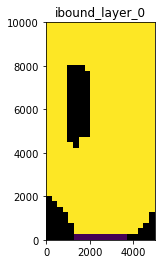

In [4]:
m.bas6.ibound[0].plot()

### We don't want pilot points or care about HK values in inactive cells, but we do need values in constant heads

We are going to use a pyemu helper function to setup pilot points are cell centers for active cells.

In [5]:
# we want hk pilot points in the top layer...
prefix_dict = {0:["hk"]} 
df_pp = pyemu.gw_utils.setup_pilotpoints_grid(ml=m,prefix_dict=prefix_dict,
                                              pp_dir=working_dir,
                                              tpl_dir=working_dir,
                                              every_n_cell=4)
pp_file = os.path.join(working_dir,"hkpp.dat")
assert os.path.exists(pp_file)

Let's look at ``df_pp`` - it has a lot of useful info

In [6]:
df_pp

,name,x,y,zone,parval1,k,i,j,tpl,parnme,tpl_filename,pp_filename,pargp,scale,parlbnd,dercom,partrans,parubnd,offset,parchglim
0,pp_0000,125.0,9875.0,1.0,1.0,0.0,0.0,0.0,~ hk00 ~,hk00,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
1,pp_0001,1125.0,9875.0,1.0,1.0,0.0,0.0,4.0,~ hk01 ~,hk01,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
2,pp_0002,2125.0,9875.0,1.0,1.0,0.0,0.0,8.0,~ hk02 ~,hk02,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
3,pp_0003,3125.0,9875.0,1.0,1.0,0.0,0.0,12.0,~ hk03 ~,hk03,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
4,pp_0004,4125.0,9875.0,1.0,1.0,0.0,0.0,16.0,~ hk04 ~,hk04,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
5,pp_0005,125.0,8875.0,1.0,1.0,0.0,4.0,0.0,~ hk05 ~,hk05,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
6,pp_0006,1125.0,8875.0,1.0,1.0,0.0,4.0,4.0,~ hk06 ~,hk06,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
7,pp_0007,2125.0,8875.0,1.0,1.0,0.0,4.0,8.0,~ hk07 ~,hk07,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
8,pp_0008,3125.0,8875.0,1.0,1.0,0.0,4.0,12.0,~ hk08 ~,hk08,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor
9,pp_0009,4125.0,8875.0,1.0,1.0,0.0,4.0,16.0,~ hk09 ~,hk09,freyberg_pp/hkpp.dat.tpl,freyberg_pp/hkpp.dat,hk,1.0,1.100000e-10,1,log,1.100000e+10,0.0,factor


So cool, we now defined pilot points as a set of spatially distributed parameters...but how do go from pilot points to the model input HK array? Answer: geostatistics.  We need to calculate the geostatistical factors (weights) used to form the interpolated value for the HK value at each model cell - its a spatially-weighted combination of pilot point values

## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First we need to define a couple geostatistical structures (e.g. variograms)

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
### $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.


### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatailly, remember?

(0, 2.0)

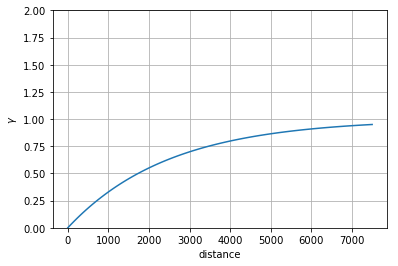

In [7]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [8]:
ok = pyemu.geostats.OrdinaryKrige(gs,df_pp)

Once the ``OrdinaryKrige`` is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

In [9]:
df = ok.calc_factors_grid(m.sr,var_filename=pst_name.replace(".pst",".var.ref"),minpts_interp=1,maxpts_interp=10)

starting interp point loop for 800 points
took 2.751627 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

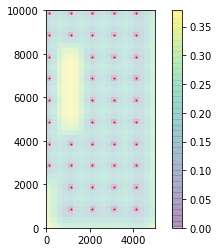

In [10]:
arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=m.sr.get_extent(),alpha=0.25)
plt.colorbar(p)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='r')

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [11]:
df

,x,y,idist,inames,ifacts,err_var
0,125.0,9875.0,[1e-07],[pp_0000],[1.0],0.000000
1,375.0,9875.0,"[250.0, 750.0, 1030.7764064, 1250.0, 1750.0, 2015.56443707, 2015.56443707, 2657.53645318, 2750.0...","[pp_0000, pp_0001, pp_0005, pp_0006, pp_0002, pp_0010, pp_0007, pp_0011, pp_0003, pp_0008]","[0.715111604668, 0.226167724149, 0.0463765196915, 0.0342076241106, -0.00320321348696, -0.0096550...",0.140830
2,625.0,9875.0,"[500.0, 500.0, 1118.03398875, 1118.03398875, 1500.0, 1802.77563773, 2061.55281281, 2500.0, 2500....","[pp_0000, pp_0001, pp_0005, pp_0006, pp_0002, pp_0007, pp_0010, pp_0011, pp_0003, pp_0008]","[0.458413199614, 0.464377804653, 0.0508575118806, 0.0569857884894, -0.00541066834881, -0.0119532...",0.185702
3,875.0,9875.0,"[250.0, 750.0, 1030.7764064, 1250.0, 1250.0, 1600.78105936, 2136.00093633, 2250.0, 2358.49528301...","[pp_0001, pp_0000, pp_0006, pp_0002, pp_0005, pp_0007, pp_0010, pp_0003, pp_0011, pp_0008]","[0.720386678143, 0.222536787607, 0.0510893761067, -0.00503252163335, 0.029942003746, -0.00918238...",0.139747
4,1125.0,9875.0,[1e-07],[pp_0001],[1.0],0.000000
5,1375.0,9875.0,"[250.0, 750.0, 1030.7764064, 1250.0, 1250.0, 1600.78105936, 1750.0, 2015.56443707, 2136.00093633...","[pp_0001, pp_0002, pp_0006, pp_0000, pp_0007, pp_0005, pp_0003, pp_0008, pp_0011, pp_0010]","[0.720182166594, 0.225898055236, 0.0501459331812, -0.00338688591553, 0.0336837693085, -0.0089270...",0.136860
6,1625.0,9875.0,"[500.0, 500.0, 1118.03398875, 1118.03398875, 1500.0, 1500.0, 1802.77563773, 1802.77563773, 2061....","[pp_0001, pp_0002, pp_0006, pp_0007, pp_0000, pp_0003, pp_0005, pp_0008, pp_0011, pp_0012]","[0.464177494802, 0.464023670197, 0.0549395010107, 0.0567447045549, -0.0031001502742, -0.00323511...",0.181602
7,1875.0,9875.0,"[250.0, 750.0, 1030.7764064, 1250.0, 1250.0, 1600.78105936, 1750.0, 2015.56443707, 2015.56443707...","[pp_0002, pp_0001, pp_0007, pp_0003, pp_0006, pp_0008, pp_0000, pp_0005, pp_0011, pp_0004]","[0.720183430568, 0.225938402178, 0.0513745833029, -0.00495543064055, 0.0326752183119, -0.0099342...",0.138044
8,2125.0,9875.0,[1e-07],[pp_0002],[1.0],0.000000
9,2375.0,9875.0,"[250.0, 750.0, 1030.7764064, 1250.0, 1250.0, 1600.78105936, 1750.0, 2015.56443707, 2015.56443707...","[pp_0002, pp_0003, pp_0007, pp_0001, pp_0008, pp_0006, pp_0004, pp_0009, pp_0011, pp_0012]","[0.720105112163, 0.225837054082, 0.0513378869468, -0.00349859027147, 0.0339125388629, -0.0093239...",0.136878


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points.  Is this clear?  

Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [12]:
ok.to_grid_factors_file(pp_file+".fac")

Just for demo purposes, lets generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [13]:
# generate random values
df_pp.loc[:,"parval1"] = np.random.random(df_pp.shape[0])
# save a pilot points file
pyemu.gw_utils.write_pp_file(pp_file,df_pp)

In [14]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.gw_utils.fac2real(pp_file,factors_file=pp_file+".fac",out_file=None)

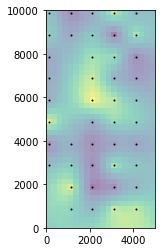

In [15]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=m.sr.get_extent(),alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='.',s=4,color='k')

What happens if you recalculate the factors using one point for every cell? Change ``max_interp_pts`` to 1 in the ``calc_factors_grid()`` and rerun these cells...

### An aside on geostatistics and covariance matrices

The ``GeoStruct`` object above was used to interpolate from pilot point locations to each node in the grid.  But this same ``GoeStruct`` also has an important information regarding how the pilot points are related to each other spatially---that is, the ``GeoStruct`` object implies a covariance matrix.  Let's form that matrix 

In [16]:
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)

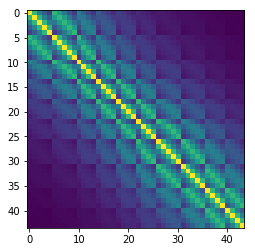

In [17]:
plt.imshow(cov.x)

In [18]:
cov.to_dataframe()

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,hk34,hk35,hk36,hk37,hk38,hk39,hk40,hk41,hk42,hk43
hk00,1.000000,0.670320,0.449329,0.301194,0.201897,0.670320,0.567971,0.408842,0.282264,0.192195,...,0.047534,0.039760,0.039760,0.036939,0.032791,0.027940,0.026725,0.025027,0.022489,0.019457
hk01,0.670320,1.000000,0.670320,0.449329,0.301194,0.567971,0.670320,0.567971,0.408842,0.282264,...,0.054364,0.047534,0.040762,0.039760,0.036939,0.032791,0.027324,0.026725,0.025027,0.022489
hk02,0.449329,0.670320,1.000000,0.670320,0.449329,0.408842,0.567971,0.670320,0.567971,0.408842,...,0.059106,0.054364,0.039760,0.040762,0.039760,0.036939,0.026725,0.027324,0.026725,0.025027
hk03,0.301194,0.449329,0.670320,1.000000,0.670320,0.282264,0.408842,0.567971,0.670320,0.567971,...,0.060810,0.059106,0.036939,0.039760,0.040762,0.039760,0.025027,0.026725,0.027324,0.026725
hk04,0.201897,0.301194,0.449329,0.670320,1.000000,0.192195,0.282264,0.408842,0.567971,0.670320,...,0.059106,0.060810,0.032791,0.036939,0.039760,0.040762,0.022489,0.025027,0.026725,0.027324
hk05,0.670320,0.567971,0.408842,0.282264,0.192195,1.000000,0.670320,0.449329,0.301194,0.201897,...,0.068339,0.055886,0.059106,0.054364,0.047534,0.039760,0.039760,0.036939,0.032791,0.027940
hk06,0.567971,0.670320,0.567971,0.408842,0.282264,0.670320,1.000000,0.670320,0.449329,0.301194,...,0.079673,0.068339,0.060810,0.059106,0.054364,0.047534,0.040762,0.039760,0.036939,0.032791
hk07,0.408842,0.567971,0.670320,0.567971,0.408842,0.449329,0.670320,1.000000,0.670320,0.449329,...,0.087764,0.079673,0.059106,0.060810,0.059106,0.054364,0.039760,0.040762,0.039760,0.036939
hk08,0.282264,0.408842,0.567971,0.670320,0.567971,0.301194,0.449329,0.670320,1.000000,0.670320,...,0.090718,0.087764,0.054364,0.059106,0.060810,0.059106,0.036939,0.039760,0.040762,0.039760
hk09,0.192195,0.282264,0.408842,0.567971,0.670320,0.201897,0.301194,0.449329,0.670320,1.000000,...,0.087764,0.090718,0.047534,0.054364,0.059106,0.060810,0.032791,0.036939,0.039760,0.040762


What do these numbers mean?  Why should you care?  Well, this covariance matrix plays an important role in uncertainty quantification, as well as in governing the way pilot point parameters are adjusted during calibration

### Building a control file using these pilot points

There's a fair amount of support in pyemu for building control files and setting PEST inferfaces.  Here we will only briefly touch on some of the basic components.  If you have created template files and instruction files, and have used our proposed naming convention, then you can quickly generate a control file using the following call

In [19]:
os.chdir(working_dir)
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)
os.chdir("..")
io_files

run():./inschek flux.dat.ins flux.dat
run():./inschek freyberg.hyd.bin.dat.ins freyberg.hyd.bin.dat
run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat


(['freyberg.rch.tpl',
  'hkpp.dat.tpl',
  'WEL_0001.dat.temp.tpl',
  'WEL_0002.dat.temp.tpl'],
 ['freyberg.rch', 'hkpp.dat', 'WEL_0001.dat.temp', 'WEL_0002.dat.temp'],
 ['flux.dat.ins',
  'freyberg.hyd.bin.dat.ins',
  'freyberg.travel.ins',
  'vol.dat.ins'],
 ['flux.dat', 'freyberg.hyd.bin.dat', 'freyberg.travel', 'vol.dat'])

The ``parse_dir_for_io_files()`` helper is looking for files with the ".tpl" and ".ins" extension.  This assumes that the corresponding model input and model output files are the same name, minus the ".tpl" and ".ins" extension, respectively.  These file lists are then passed to another helper, which builds a basic control file for you (``Pst.from_io_files()``).  Let's look at this generic ``Pst`` instance:

In [20]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
rch_0,rch_0,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk00,hk00,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk01,hk01,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk02,hk02,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk03,hk03,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk04,hk04,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk05,hk05,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk06,hk06,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk07,hk07,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1



Cool - the other tpl files were found and parsed - parameter listed in them were added to the control file.  But we have generic entries for initial values bounds...

In [21]:
pst.observation_data

,obsnme,obsval,weight,obgnme
flx_constan_19700102,flx_constan_19700102,-3.062889e+02,1.0,obgnme
flx_in-out_19700102,flx_in-out_19700102,-6.129400e+00,1.0,obgnme
flx_percent_19700102,flx_percent_19700102,-1.000000e-01,1.0,obgnme
flx_recharg_19700102,flx_recharg_19700102,6.081250e+03,1.0,obgnme
flx_river_l_19700102,flx_river_l_19700102,-3.781091e+03,1.0,obgnme
flx_storage_19700102,flx_storage_19700102,0.000000e+00,1.0,obgnme
flx_total_19700102,flx_total_19700102,-6.129395e+00,1.0,obgnme
flx_wells_19700102,flx_wells_19700102,-2.000000e+03,1.0,obgnme
flx_constan_19750101,flx_constan_19750101,-9.774780e+01,1.0,obgnme
flx_in-out_19750101,flx_in-out_19750101,5.977000e-01,1.0,obgnme


also cool - the instruction files in the directory were also found and parsed so that observation listed in the instruction files were added as well. There are some subtlies here, but we will skip them for now.

## Regularization

Regularization is ....

in pyemu, we can add two forms of regularization:
- preferred value: we want the parameter values to stay as close to the initial values as possible
- preferred difference: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  pyemu uses a helper for this:

In [22]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [23]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

In [24]:
pst.prior_information

,equation,obgnme,pilbl,weight
0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,1.0
1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,1.0
2,1.0 * log(hk00) = 6.989700E-01,regulhk,hk00,1.0
3,1.0 * log(hk01) = 6.989700E-01,regulhk,hk01,1.0
4,1.0 * log(hk02) = 6.989700E-01,regulhk,hk02,1.0
5,1.0 * log(hk03) = 6.989700E-01,regulhk,hk03,1.0
6,1.0 * log(hk04) = 6.989700E-01,regulhk,hk04,1.0
7,1.0 * log(hk05) = 6.989700E-01,regulhk,hk05,1.0
8,1.0 * log(hk06) = 6.989700E-01,regulhk,hk06,1.0
9,1.0 * log(hk07) = 6.989700E-01,regulhk,hk07,1.0


Ok, that's fine, but should the weight on preferring HK not to change be the same as preferring recharge not to change?  Seems like we would want recharge to change less than HK.  This preference can be expressed by using the parameter bounds to form the weights

In [25]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=True)

In [26]:
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,4.507576
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,4.507576
hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,hk00,0.500000
hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,hk01,0.500000
hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,hk02,0.500000
hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,hk03,0.500000
hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,hk04,0.500000
hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,hk05,0.500000
hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,hk06,0.500000


Now we are really preferring recharge not to change...good!

So what about preferred difference regularization?  Well pyemu can do that too.  Remember that ``Cov``ariance matrix we built above? It expresses the spatial relationship between pilot points, so we use to setup these prior information equations:

In [27]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

In [28]:
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_59,1.0 * log(hk00) - 1.0 * log(hk01) = 0.0,regul_cc,pcc_59,0.670320
pcc_60,1.0 * log(hk00) - 1.0 * log(hk02) = 0.0,regul_cc,pcc_60,0.449329
pcc_61,1.0 * log(hk00) - 1.0 * log(hk03) = 0.0,regul_cc,pcc_61,0.301194
pcc_62,1.0 * log(hk00) - 1.0 * log(hk04) = 0.0,regul_cc,pcc_62,0.201897
pcc_63,1.0 * log(hk00) - 1.0 * log(hk05) = 0.0,regul_cc,pcc_63,0.670320
pcc_64,1.0 * log(hk00) - 1.0 * log(hk06) = 0.0,regul_cc,pcc_64,0.567971
pcc_65,1.0 * log(hk00) - 1.0 * log(hk07) = 0.0,regul_cc,pcc_65,0.408842
pcc_66,1.0 * log(hk00) - 1.0 * log(hk08) = 0.0,regul_cc,pcc_66,0.282264
pcc_67,1.0 * log(hk00) - 1.0 * log(hk09) = 0.0,regul_cc,pcc_67,0.192195


What happened?  We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the pearson correlation coefficients (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! 